In [179]:
#Packages
import tensorflow as tf
import numpy as np
from skimage.transform import resize
import importlib
import pandas as pd
from tensorflow.keras.layers import Input # type: ignore
from tensorflow.keras.models import Model # type: ignore
import sys, os
import matplotlib.pylab as plt
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), "..","..","..","..","onn"))
import dnn # type: ignore


### 1 Build Model and Train

#### 1.0 Build model

In [180]:
from tensorflow.keras.layers import Resizing
import importlib
importlib.reload(dnn)

def get_model(x, y, lam, z1, z2, z3, Dmeta , Nmeta = 28,  method = "RS_FFT"):

    #Get Detector   
    Dx = x[-1]-x[0]
    Dy = y[-1]-y[0]
    detector = dnn.loadDetector(Dx=Dx , Dy=Dy, x=x, y=y)
    shape = (len(y), len(x))
    Ny, Nx = shape

    # Define the Model Layers
    input_layer = Input(shape = (28,28))
    out = tf.transpose(Resizing(Ny, Nx)(tf.transpose(input_layer)))
    out = tf.cast(out, tf.complex64)
    #out = dnn.FreeSpacePropagation(x, y, z1, lam, method = method)(out)
    out = dnn.Meta(x, y, lam, Nmeta, Dmeta, Dmeta)(out)
    out = dnn.FreeSpacePropagation(x, y, z2, lam, method = method)(out)
    out = dnn.Meta(x, y, lam, Nmeta, Dmeta, Dmeta)(out) 
    out = dnn.FreeSpacePropagation(x, y, z3, lam, method = method)(out)
    output_layer = dnn.ToDetector(detector)(out)
    
    # Build Model
    model = Model(inputs=input_layer, outputs=output_layer, name="model")

    # Optimize Parameters
    learning_rate = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Compile Model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)

    return model

def get_model_lens(x, y, lam, z1, z2, z3, Dmeta , zin, zout, f, R = None, Nmeta = 28,  method = "RS_FFT"):

    #Get Detector   
    Dx = x[-1]-x[0]
    Dy = y[-1]-y[0]
    detector = dnn.loadDetector(Dx = Dx , Dy = Dy, x =  x, y = y)
    shape = (len(y), len(x))
    Ny, Nx = shape

    # Define the Model Layers
    input_layer = Input(shape = (28,28))
    out = tf.transpose(Resizing(Ny, Nx)(tf.transpose(input_layer))) 
    out = tf.cast(out, tf.complex64)
    out = dnn.FreeSpacePropagation(x, y, z1, lam, method = method)(out)
    out = dnn.Meta(x, y, lam, Nmeta, Dmeta, Dmeta)(out)
    out = dnn.FreeSpacePropagation(x, y, z2, lam, method = method)(out)
    out = dnn.Meta(x, y, lam, Nmeta, Dmeta, Dmeta)(out) 
    out = dnn.FreeSpacePropagation(x, y, z3, lam, method = method)(out)
    out = dnn.Lens(x, y, zin, zout, lam, f, R)(out)
    output_layer = dnn.ToDetector(detector)(out)
    
    # Build Model
    model = Model(inputs=input_layer, outputs=output_layer, name="model")

    # Optimize Parameters
    learning_rate = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Compile Model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)

    return model

#enter everything in units of lambda
def trainModel(x, y, lam, z1, z2, z3, D , Nmeta = 28, batch_size = 8, epochs = 3, verbose = 1, method = "RS_FFT", weights = False):

    #Load Model
    model = get_model(x, y, lam, z1, z2, z3, D , Nmeta=Nmeta, method = method)
    if weights:
        try:
            model.set.weights(weights)
        except:
            print("Weights have wrong dimensions, training from scratch")

    #Load Trainings and validation data # Normalize and Resize
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = (x_train/255., x_test/255.)

    # Train Model
    history = model.fit(x_train, y_train,
        batch_size = batch_size,
        shuffle    = True,
        verbose    = verbose,
        epochs     = epochs,
        callbacks  = tf.keras.callbacks.EarlyStopping(patience=2),
        validation_data = (x_test, y_test))
    
    return model, history


tf.Tensor([  5 113 113], shape=(3,), dtype=int32)


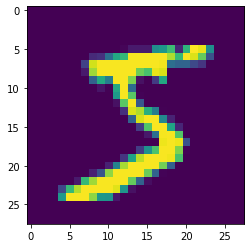

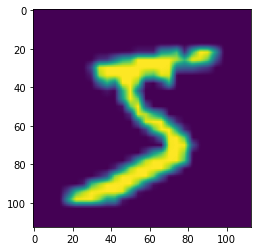

In [16]:
from tensorflow.keras.layers import Resizing

#Physical Parameters
lam        = 0.785e-6                  #wavelength in nm
N_meta     = 28                        #number of output pixels, in one dimension
D          = 2*28*lam
z1    = 32                    
z2    = 50e-6                   
z3    = 2e-2
dx    = lam/2
x = y = np.arange(-D/2, D/2+dx, dx )*2
shape = (len(y), len(x))
Ny, Nx = shape

#Load Data
#Load Trainings and validation data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and Resize
x_train, x_test = (x_train/255., x_test/255.)

# Resize sample
x_resized = tf.transpose(Resizing(Ny, Nx)(tf.transpose(x_train[0:5])))
print(tf.shape(x_resized))

plt.figure()
plt.imshow(x_train[0])
plt.show()

plt.figure()
plt.imshow(x_resized[0])
plt.show()

### Train for 50µm interlayer distance

In [46]:
#Physical Parameters
lam        = 1        # 0.785e-6     #wavelength in nm
N_meta     = 28                      #number of output pixels, in one dimension
p          = 1        #5:3.92µm /4:3.14µm
D          = 28*p     #110mm /87.92µm 
z1         = 30*p**2  #590µm /376.8µm       
z2         = 12*p**2  #235µm /150.72µm                 
z3         = 500*p**2 #9.813mm /6.28µm
dx         = lam/2
x = y = np.arange(-D/2, D/2 + dx, dx )

#Display Model
model, history = trainModel(x, y, lam, z1, z2, z3, D)
file = "Optim_28x28_01.npy"
np.save(file, model.get_weights())

Epoch 1/3
7500/7500 [==============================] - 1072s 143ms/step - loss: 1.8375 - sparse_categorical_accuracy: 0.6808 - val_loss: 1.7066 - val_sparse_categorical_accuracy: 0.8435
Epoch 2/3
7500/7500 [==============================] - 1317s 176ms/step - loss: 1.6959 - sparse_categorical_accuracy: 0.8400 - val_loss: 1.6784 - val_sparse_categorical_accuracy: 0.8659
Epoch 3/3
7500/7500 [==============================] - 1507s 201ms/step - loss: 1.6793 - sparse_categorical_accuracy: 0.8532 - val_loss: 1.6795 - val_sparse_categorical_accuracy: 0.8582


In [ ]:
#Get Weights
w = model.get_weights()

#Plot Weights
res = np.zeros((2,28,28))
y = w[0]
y[y<0] +=1
y[y>1] -=1
plt.figure()
plt.imshow(np.reshape(y, (28,28)), cmap = "twilight")
plt.colorbar()
res[0] = np.reshape(y, (28,28))

y = w[2]
y[y<0] +=1
y[y>1] -=1
plt.figure()
plt.imshow(np.reshape(y, (28,28)), cmap = "twilight")
plt.colorbar()
res[1] = np.reshape(y, (28,28))

#save
file = "Optim_28x28_01_scaledWeights.npy"
np.save(file, res)
print(np.shape(np.load(file)))

### Scale system up and test accuracy

In [63]:
#Physical Parameters
lam        = 1        # 0.785e-6     #wavelength in nm
N_meta     = 28                      #number of output pixels, in one dimension
p          = 4        #3.92µm 
D          = 28*p     #87.92m 
z1         = 30*p**2  #376.8µm          
z2         = 12*p**2  #150.72µm                 
z3         = 500*p**2 #6.28mm
dx         = lam/2
x = y = np.arange(-D/2, D/2 + dx, dx )

# Display Model
model_large = get_model(x, y, lam, z1, z2, z3, D)
model_large.set_weights(model.get_weights())


# Get accuracy for transfered model (use smaller subset of data)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = (x_train/255., x_test/255.)

print("validation")
model_large.evaluate(x_test[:1000], y_test[:1000], verbose = 1, batch_size = 100)
print("training")
model_large.evaluate(x_train[:1000], y_train[:1000], verbose = 1, batch_size = 100)

validation
10/10 [==============================] - 142s 14s/step - loss: 2.1199 - sparse_categorical_accuracy: 0.2750
training
10/10 [==============================] - 141s 14s/step - loss: 2.0885 - sparse_categorical_accuracy: 0.3230


[2.0885350704193115, 0.3230000138282776]

In [72]:
# Continue Trainig with initial weights of smaller model (without validation data for speed)
# model_large.set_weights("Optim_28x28_01_p4.npy")
# INTERRUPTED ON PURPOSE
model_large.fit(x_train[4000:6000], y_train[4000:6000],
    batch_size = 8,
    shuffle    = True,
    verbose    = 1,
    epochs     = 1,
    validation_data = (x_test[:1000], y_test[:1000]))
np.save("Optim_28x28_01_p4.npy", model_large.get_weights())

 92/250 [==========>...................] - ETA: 9:32 - loss: 1.7417 - sparse_categorical_accuracy: 0.8003

KeyboardInterrupt: 

In [73]:
print("validation")
model_large.evaluate(x_test[:1000], y_test[:1000], verbose = 1, batch_size = 100)
print("training")
model_large.evaluate(x_train[:1000], y_train[:1000], verbose = 1, batch_size = 100)

validation
10/10 [==============================] - 228s 23s/step - loss: 1.7711 - sparse_categorical_accuracy: 0.7560
training
10/10 [==============================] - 212s 21s/step - loss: 1.7397 - sparse_categorical_accuracy: 0.7980


[1.7396502494812012, 0.7979999780654907]

(4, 28, 28)


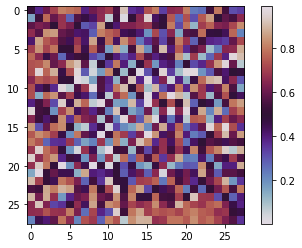

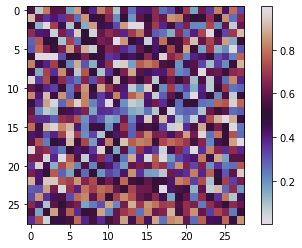

In [107]:
#Get Weights
w = model_large.get_weights()

#Plot Weights
res = w
y = w[0]
y[y<0] +=1
y[y>1] -=1
plt.figure()
plt.imshow(y, cmap = "twilight")
plt.colorbar()
res[0] = y

y = w[2]
y[y<0] +=1
y[y>1] -=1
plt.figure()
plt.imshow(y, cmap = "twilight")
plt.colorbar()
res[2] = y

#save
file = "Optim_28x28_01_p4_scaledWeights.npy"
np.save(file, res)
print(np.shape(np.load(file)))

### Repeat with more reasonable Paramaters

In [182]:
#Physical Parameters
lam        = 1        # 0.785e-6     # wavelength in nm
N_meta     = 56                      # number of output pixels, in one dimension
p          = 2              #1.57µm 
D          = 28*4*lam   #87.92m 
z1         = 30*4**2*lam    #376.8µm          
z2         = 15*4**2*lam    #188.4µm                 
z3         = 100*4**2*lam   #1.256mm
dx         = lam/2
x = y = np.arange(-D/2, D/2 + dx, dx )

# Train Model
model_large = get_model(x, y, lam, z1, z2, z3, D, N_meta)
weights = np.load("Optim_28x28_01_p4_reasonable.npy")
weights = tf.transpose(Resizing(N_meta,N_meta)(tf.transpose(weights)))
model_large.set_weights(weights)

# Continue Trainig with initial weights of smaller model (without validation data for speed)
thresh = True
start  = 0
while thresh:
    model_large.fit(x_train[start:10000], y_train[start:10000],
        batch_size = 8,
        shuffle    = True,
        verbose    = 1,
        epochs     = 1,
        callbacks  = tf.keras.callbacks.EarlyStopping(patience=2))
    if model_large.evaluate(x_test[:100], y_test[:100])[1]> 0.88:
        thresh = False
        start +=2000

    
np.save("Optim_56x56_01_p4_reasonable.npy", w)



  42/1250 [>.............................] - ETA: 25:06 - loss: 1.9449 - sparse_categorical_accuracy: 0.5208

In [ ]:
# Scale weights
w = model_large.get_weights()

res = w
y = w[0]
y[y<0] +=1
y[y>1] -=1
res[0] = y
y = w[2]
y[y<0] +=1
y[y>1] -=1
res[2] = y
np.save("Optim_56x56_01_p4_reasonable_Scaled.npy", res)

model_large.evaluate(x_test[:500], y_test[:500])
model_large.evaluate(x_train[:500], y_train[:500])

16/16 [==============================] - 44s 3s/step - loss: 1.6166 - sparse_categorical_accuracy: 0.9000


[1.6166383028030396, 0.8999999761581421]

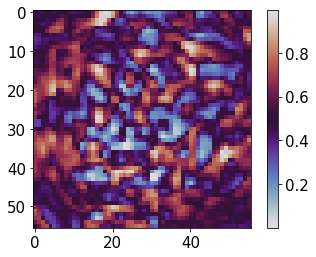

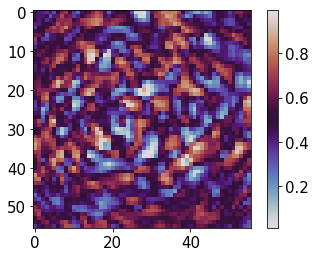

In [ ]:
res = np.load("Optim_56x56_01_p4_reasonable_scaled.npy")

#Plot Weights
plt.figure()
plt.imshow(res[0], cmap = "twilight")
plt.colorbar()
plt.show()
plt.close()

plt.figure()
plt.imshow(res[2], cmap = "twilight")
plt.colorbar()
plt.show()
plt.close()

### Check propagation through system
Here I just want to take a look at the propagated light at every layer to make sure it looks "healthy"

In [175]:
import importlib
importlib.reload(dnn)
det= np.sum(dnn.loadDetector( Dx=D, Dy=D,x=x, y=x),axis = 0)


112
112.0


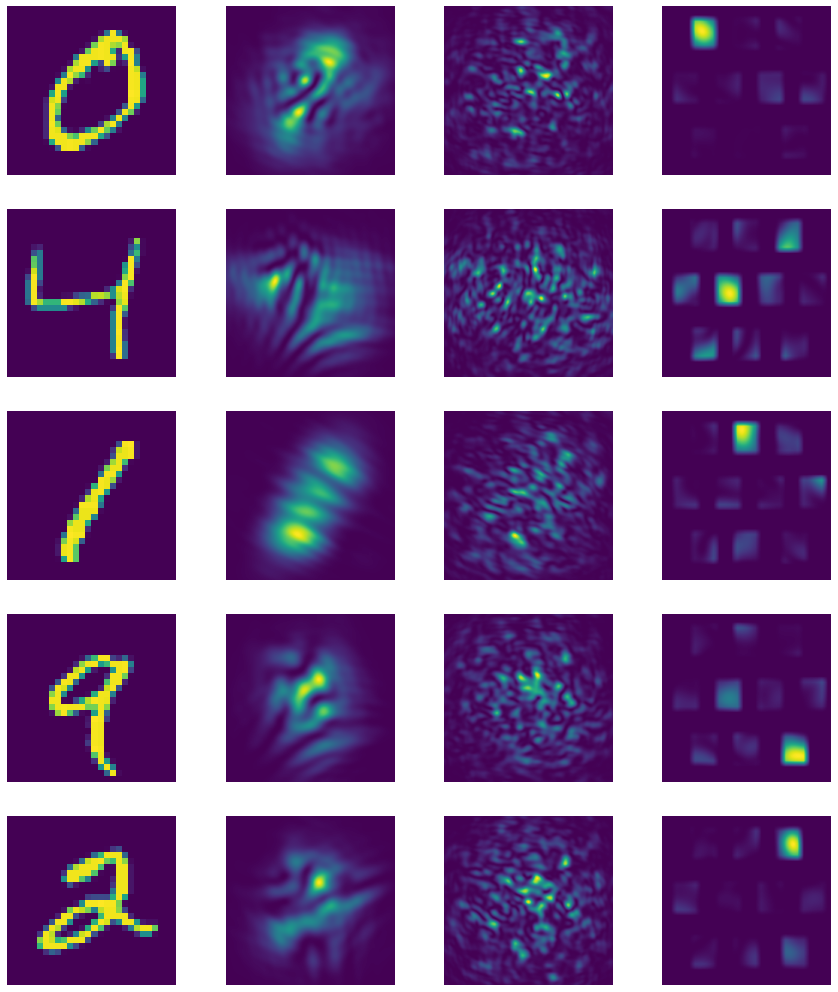

In [178]:
layer = [1,2,3,4,5,6,7]
in_   = x_train[1:9]

#model_large.set_weights(np.load("Optim_28x28_01_p4_reasonable.npy"))
layer = ['input_13', 'free_space_propagation_36',  'free_space_propagation_37', 'free_space_propagation_38']
fig, ax = plt.subplots(5,len(layer), figsize= (15,18))
for i,l in enumerate(layer):
    # Get Layer output
    out = Model(inputs = model_large.input,  outputs = model_large.get_layer(l).output)(in_)
    detector = 1
    if i ==3:
        detector = det
    # Plot
    ax[0,i].imshow(np.abs(out[0])**2*detector)
    ax[1,i].imshow(np.abs(out[1])**2*detector)
    ax[2,i].imshow(np.abs(out[2])**2*detector)
    ax[3,i].imshow(np.abs(out[3])**2*detector)
    ax[4,i].imshow(np.abs(out[4])**2*detector)
for ax_ in ax.reshape(-1):
    ax_.axis("off")
plt.show()
fig.tight_layout()
plt.close()

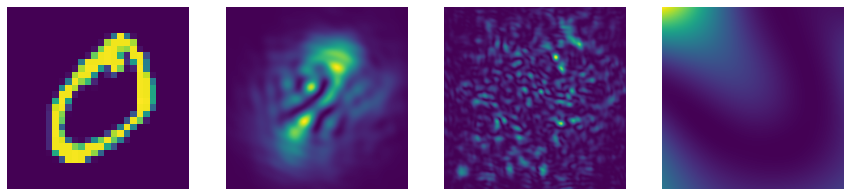

In [106]:
#Other system (one)

#Physical Parameters
lam        = 1        # 0.785e-6     #wavelength in nm
N_meta     = 28                      #number of output pixels, in one dimension
p          = 4        #3.92µm 
D          = 28*p     #87.92m 
z1         = 30*p**2  #376.8µm          
z2         = 12*p**2  #150.72µm                 
z3         = 500*p**2 #6.28mm
dx         = lam/2
x = y = np.arange(-D/2, D/2 + dx, dx )

# Display Model
#model_large = get_model(x, y, lam, z1, z2, z3, D)
#model_large.set_weights(np.load("Optim_28x28_01_p4.npy"))

#Plot propagation
in_   = x_train[:2]
layer = ['input_10', 'free_space_propagation_27',  'free_space_propagation_28', 'free_space_propagation_29']
fig, axs = plt.subplots(1,len(layer), figsize= (15,7))
for ax,l in zip(axs,layer):
    # Get Layer output
    out = Model(inputs = model_large.input,  outputs = model_large.get_layer(l).output)(in_)
    # Plot
    im = ax.imshow(np.abs(out[1])**2)
    #plt.colorbar(im = im, ax = ax)
    ax.axis("off")
plt.show()
fig.tight_layout()
plt.close()

### Testing this setup if we add an objctive

Sven muss system 2 (prefarably abbilden), kann das functionieren? Jedes objectiv hat eine gewisse focal depth und ist diffraction limited.

In [ ]:
tf.keras.backend.clear_session()

#Physical Parameters
lam        = 1        # 0.785e-6     # wavelength in nm
N_meta     = 28                      # number of output pixels, in one dimension
p          = 4        #3.92µm 
D          = 28*p  *lam   #87.92m 
z1         = 30*p**2*lam  #376.8µm          
z2         = 15*p**2*lam  #188.4µm                 
z3         = 100*p**2*lam #1.256mm
dx         = lam/2
x = y = np.arange(-D/2, D/2 + dx, dx )

# Lens setup paraneters
zin, zout, f = 

# Train Model
model_lens = get_model_with_lens(x, y, lam, z1, z2, z3, D, zin, zout, f)
model_lens.set_weights(np.load("Optim_28x28_01_p4_reasonable.npy")) #weights from system without lens

In [ ]:
model_large.evaluate(x_test[:500], y_test[:500])
model_large.evaluate(x_train[:500], y_train[:500])

In [ ]:
#Plot propagation
in_   = x_train[:2]
layer = ['input_10', 'free_space_propagation_27',  'free_space_propagation_28', 'free_space_propagation_29']
fig, axs = plt.subplots(1,len(layer), figsize= (15,7))
for ax,l in zip(axs,layer):
    # Get Layer output
    out = Model(inputs = model_large.input,  outputs = model_large.get_layer(l).output)(in_)
    # Plot
    im = ax.imshow(np.abs(out[1])**2)
    #plt.colorbar(im = im, ax = ax)
    ax.axis("off")
plt.show()
fig.tight_layout()
plt.close()